## Set-Up

In [1]:
import torch
import torch

num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

2


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..\..\..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from pprint import pprint
from torchinfo import summary
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import segmentation_models_pytorch as smp
import json
import gc

import src.config as config

from src.models.model_creator import SegmentationModel

from src.utils import (
            visualize,
            gpu_checker,
            set_seed,
            resutls_to_csv,
            get_last_checkpoint,
            get_checkpoint_callback,
            get_early_stop_callback,
            get_data_loaders)

from src.dataset import Dataset
from src.data_augment import get_training_augmentation

F:\DR


## Configuration

In [3]:
DDR_EX_dataset = {
"x_train_dir": r"F:\DDR-dataset\DDR-dataset\lesion_segmentation\train\image",
"y_train_dir": r"F:\DDR-dataset\DDR-dataset\lesion_segmentation\train\label\EX",

"x_valid_dir": r"F:\DDR-dataset\DDR-dataset\lesion_segmentation\valid\image",
"y_valid_dir": r"F:\DDR-dataset\DDR-dataset\lesion_segmentation\valid\label\EX",

"x_test_dir": r"F:\DDR-dataset\DDR-dataset\lesion_segmentation\test\image",
"y_test_dir": r"F:\DDR-dataset\DDR-dataset\lesion_segmentation\test\label\EX",
}

cosed_net_v2= {
  "NAME": "cosed_net",
  "ARCH":'unetplusplus',
  "SMP_MODEL_NAME":'efficientnet-b4',
  "PRETRAINED": 'imagenet',
  "ATTENTION": 'scse',
  "LOGGER_DIR": r"F:\DR\DDR\DDR_EX\cosed_net\weights_and_logs",
  "CKPT_NAME": "cosed_net-{epoch:02d}-{train_loss:.2f}",
  "CKPT_DIR": r"F:\DR\DDR\DDR_EX\cosed_net\weights_and_logs",
  "LAST_CKPT_DIR": None,
  "LAST_CKPT": r"F:\DR\DDR\DDR_EX\cosed_net\weights_and_logs\last.ckpt"
}

resutls_csv_dir= r"F:\DR\DDR\DDR_EX\Results\ddr_ex_results.csv"

In [4]:
import pandas as pd
# score_board_template = pd.DataFrame(columns={"model_name", "test_mean_iou", "test_mean_F1",	"test_mean_accuracy",	"test_mean_precision", "test_mean_recall", "test_loss"})
# score_board_template.to_csv(resutls_csv_dir, index=False)
test = pd.read_csv(resutls_csv_dir)
test

,model_name,test_loss,test_mean_accuracy,test_mean_recall,test_mean_precision,test_mean_iou,test_mean_F1
0,cosed_net,1.52,99.81,46.29,74.18,39.87,57.01
1,cosed_net_v2,2.51,99.80,41.12,75.43,36.26,53.22
2,dense_unet,1.15,99.79,41.78,70.91,35.67,52.58
3,unet_plusplus,1.18,99.79,29.00,84.86,27.58,43.23
4,unet,1.26,99.79,32.97,76.26,29.90,46.03
5,deeplabv3,57.30,99.78,28.55,75.37,26.11,41.41
6,cosed_net_LE_DCE,50.40,99.79,33.06,79.46,30.46,46.69
7,cosed_net_LE_DCE_TL,50.53,99.81,45.96,74.07,39.59,56.72
8,dense_unet,4.02,99.72,0.00,0.08,0.00,0.00


## Database Visualisation

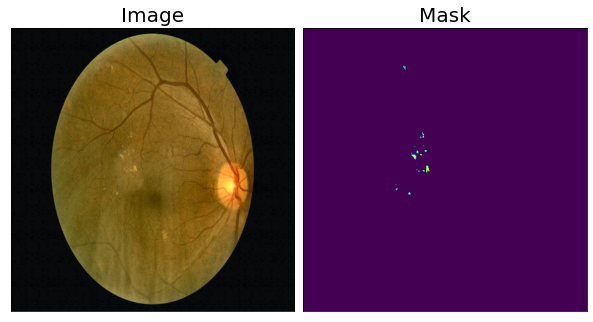

In [5]:
augmented_dataset_paths = DDR_EX_dataset
augmented_dataset = Dataset(
    augmented_dataset_paths["x_train_dir"], 
    augmented_dataset_paths["y_train_dir"], 
    augmentation=get_training_augmentation(),
    # preprocessing=get_preprocessing()
    )


image, mask = augmented_dataset[230]
assert mask.max() <= 1.0 and mask.min() >= 0
visualize(image=image, mask=mask.squeeze(-1))

## Model Traning 

In [9]:
"""
This is the main file that will run the training and validation of the model.
It will also save the model and the training history to the specified folder
for further possibility to apply TensorBoard.
Addionally, the model would be evaluated on the test set from a specified dataset 
and its results would be saved to the specified csv file for further analysis.

"""


# Initial Checks using the set_seed function to reset the random seed 
# and the gpu_checker function to check if there is a GPU available.
set_seed()
gpu_checker()


"""
  Model Configuration
"""

# Assign the spesifed model's configuration from the config.py file. 
# to the model_setup variable 
# If you want to use a different model change this accordingly.
model_setup = cosed_net_v2

# Specifying  the model's name
NAME = model_setup["NAME"]

# Specifying the model's basline architecture
# For example, if you want to use the U-Net architecture,
# you would should specify that under the model's configuration in the config.py file
ARCH = model_setup["ARCH"]

# Specifying the model's specific Segmentation Models Pytorch name
SMP_MODEL_NAME = model_setup["SMP_MODEL_NAME"]

# Specifying if the model should use pretrained weights or not
PRETRAINED = model_setup["PRETRAINED"]

# Specifying if the model should use 
# the Special and Channel "Squeeze and Exitstation" (scSE) block or not
ATTENTION = model_setup["ATTENTION"]

# Specifying the directory to log the traing process
LOGGER_DIR = model_setup['LOGGER_DIR']
LOGGED_DATA = f"{LOGGER_DIR}/{NAME}_logs"

# Specifying the directory to save the model's weights and hyperparameters
CKPT_DIR = model_setup["CKPT_DIR"]
CKPT_NAME = model_setup["CKPT_NAME"]
LAST_CKPT_DIR = model_setup["LAST_CKPT_DIR"]


# Additional configurations

# FAST_DEV_RUN is used to specify 
# if the Trainer should only run for one training and validation epoch
FAST_DEV_RUN=False

# Specifying the number of epochs for the training
NUM_EPOCHS=300

# Specifying the size of the training mini-batch
TRAIN_BATCH=8
# Specifying the size of the validation mini-batch
VAL_BATCH=8

# Specifying the size of the testing mini-batch
TEST_BATCH=1

# Specifying the number of workers for the data loader
# here the number of workers is set to 0 given the lower 
# computation resources of the local machine
NUM_WORKERS=0


# Specifying the chosen dataset
# if another dataset is selected, then change this variable accordingly
# based on the specific dataset's configuration in the config.py file
dataset = DDR_EX_dataset


"""
  Model Initialisation
"""

# Initialisation of the checkpoint callback functions
checkpoint = get_checkpoint_callback(ckpt_dir=CKPT_DIR, 
                                     ckpt_name=CKPT_NAME)
last_checkpoint = get_last_checkpoint(LAST_CKPT_DIR)

# Initialisation of the diffrent dataloaders from the get_data_loaders function in the utils.py file
# based on the dataset's configuration in the config.py file 
# followed by the different batch sizes and number of workers
train_loader, valid_loader, test_loader = get_data_loaders(dataset['x_train_dir'], 
                                                           dataset['y_train_dir'],
                                                           dataset['x_valid_dir'],
                                                           dataset['y_valid_dir'], 
                                                           dataset['x_test_dir'], 
                                                           dataset['y_test_dir'],
                                                           train_batch=TRAIN_BATCH,
                                                           valid_batch=VAL_BATCH,
                                                           test_batch=TEST_BATCH,
                                                           num_workers=NUM_WORKERS)


# Creating the neural network model using the SegmentationModel class
# imported from models.transfer_attention_u_effnet_plusplus.model_creator file
# and the model's configuration from the config.py file such as the following
# architecture, pretrained weights, attention block, encoder's name, etc.
# For additional class arguments please refer to the model_creator in the models directory folder
model = SegmentationModel(arch=ARCH, 
                    encoder_name=SMP_MODEL_NAME,
                    pretrained=PRETRAINED,
                    attention_type=ATTENTION)
print(summary(model,  input_size=(2, 3, 512, 512)))
# Create the additional Tensor Board Logger
logger = TensorBoardLogger(save_dir=LOGGED_DATA, 
                           name=NAME, 
                           )


"""
  Model Training
  The Trainer class is initialized with the following arguments:

  Args: 
    gpus: number of GPUs to use
    max_epochs: number of epochs to train and validate
    fast_dev_run: if True, only train for one epoch
    resume_from_checkpoint: if True, resume training from last checkpoint
    callbacks: list of callbacks to use
    checkpoint_callback: checkpoint callback to use
    logger: logger to use (TensorBoardLogger)
"""

trainer = pl.Trainer(
    accelerator="gpu", 
    devices=[1],
    max_epochs=NUM_EPOCHS,
    fast_dev_run=FAST_DEV_RUN,
    resume_from_checkpoint=last_checkpoint,
    callbacks=[checkpoint],
    logger=logger
)

# The Trainer class is fitter to the specified training 
# and validation dataset using the specified dataloaders 
# and the specified model
"""
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader,
)
"""

The random seed has been reset
GPU is available


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Layer (type:depth-idx)                                            Output Shape              Param #
SegmentationModel                                                 --                        --
├─UnetPlusPlus: 1                                                 --                        --
│    └─EfficientNetEncoder: 2                                     --                        --
│    │    └─ModuleList: 3-1                                       --                        16,740,824
├─UnetPlusPlus: 1-1                                               [2, 1, 512, 512]          --
│    └─EfficientNetEncoder: 2-1                                   [2, 3, 512, 512]          --
│    │    └─Conv2dStaticSamePadding: 3-2                          [2, 48, 256, 256]         1,296
│    │    └─BatchNorm2d: 3-3                                      [2, 48, 256, 256]         96
│    │    └─MemoryEfficientSwish: 3-4                             [2, 48, 256, 256]         --
│    └─UnetPlusPlusDecoder: 2-2   

'\ntrainer.fit(\n    model, \n    train_dataloaders=train_loader, \n    val_dataloaders=valid_loader,\n)\n'

## Model Validation

In [10]:
model = SegmentationModel.load_from_checkpoint(model_setup["LAST_CKPT"])

val_metrics= trainer.validate(model, 
                           dataloaders=valid_loader,
                           verbose=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\cosednet\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\envs\cosednet\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.5004534125328064
       val_mean_F1          0.6260178089141846
    val_mean_accuracy       0.9996460676193237
      val_mean_iou          0.45562294125556946
   val_mean_precision       0.6083915829658508
     val_mean_recall        0.6446957588195801
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Model Testing

In [11]:
"""
  Model Testing

  The following code will test the model on the test dataset
  and save the results to the specified csv file.

  The test function is used from the Trainer class with the following arguments:

  Args: 
    model: model to test
    dataloaders: dataloaders to test on
    verbose: if True, print the results
"""
test_metrics= trainer.test(model, 
                           dataloaders=test_loader,
                           verbose=True)

# The average metric results are saved to the specified csv file
resutls_to_csv(resutls_csv_dir, test_metrics, NAME)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\envs\cosednet\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5049784183502197
      test_mean_F1          0.5700836777687073
   test_mean_accuracy       0.9980953931808472
      test_mean_iou         0.39868324995040894
   test_mean_precision      0.7418429255485535
    test_mean_recall        0.46290668845176697
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


PermissionError: [Errno 13] Permission denied: 'F:\\DR\\DDR\\DDR_EX\\Results\\ddr_ex_results.csv'

In [7]:
%reload_ext tensorboard
%tensorboard --logdir="{LOGGED_DATA}"

SyntaxError: invalid syntax (1840943446.py, line 1)